In [46]:
# just some boring imports
from typing import Set, Tuple, Iterable, Callable, List, Dict
from types import MethodType
from functools import partial
import re
import timeit

import marisa_trie
import numpy as np
import matplotlib.pyplot as plt
from pympler.asizeof import asizeof
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

%load_ext memory_profiler
%matplotlib inline

# small decorator to split class definitions over several slides
def add_to_class(cls):
    def decorator(fn):
        setattr(cls, fn.__name__, fn)
        return fn
    return decorator

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Datastructures and Algorithms for spell checking and correction

By Robin Hundt  
<br>
Git: https://gitlab.gwdg.de/robinwilliam.hundt/programming-pearls-spelling-checker

Steve Johnsons first version of spell, 1975.

``` bash
prepare filename |                 # remove formatting commands
    translit A-Z a-z |             # map upper to lower case
        translit ^a-z @n |         # remove punctuation
            sort |                 # put words in alphabetical order
                unique |           # remove duplicate words
                    common -2 dict # report words not in dictionary
```
(from "Programming Pearls, a spelling checker. Jon Bentley. Communications of the ACM, May 1985 Volume 28 Number 5")

- 1975 Steve Johnson wrote first version of spell
- spent one afternoon combining 6 unix programs into a new useful one
- later became standard unix spell checker for english

# Overview of the talk

##  Spell checking<br>
- Primitive implementation
- Trie data structure  

## Spell correcting<br>
- String metrics
- Corrector based on SymSpell algorithm

## Specification of spell checker
![](spell-checker-diagram.svg)

In [2]:
def spell(filename: str, word_dict: str) -> Set[str]:
    w = set(word_dict.lower().split('\n'))
    with open(filename) as f:
        return set(re.sub(r"[^a-z]", "\n", f.read().lower()).split('\n')) - w

`spell` like spelling checker in just 4 lines of python (excl. imports) by utilizing the standard libraries.   
Obvious shortcomings like converting `isn't` to `isn` and `t` because punctuation is stripped.

### Our test file (thanks to [Peter Norvig](http://norvig.com/))

In [3]:
!echo word count: $(wc -w big.txt) '\n'
!head -n 5000 big.txt | tail -n 1

word count: 1095695 big.txt 

"You can easily imagine, Mr. Holmes, how curious I became as to what the meaning of this extraordinary performance could possibly be. They were always very careful, I observed, to turn my face away from the window, so that I became consumed with the desire to see what was going on behind my back. At first it seemed to be impossible, but I soon devised a means. My hand-mirror had been broken, so a happy thought seized me, and I concealed a piece of the glass in my handkerchief. On the next occasion, in the midst of my laughter, I put my handkerchief up to my eyes, and was able with a little management to see all that there was behind me. I confess that I was disappointed. There was nothing. At least that was my first impression. At the second glance, however, I perceived that there was a man standing in the Southampton Road, a small bearded man in a grey suit, who seemed to be looking in my direction. The road is an important highway, and there are usually 

### Standard unix english dictionary file

In [4]:
!echo word count: $(wc -w /usr/share/dict/words) '\n'
!head -n 5000 /usr/share/dict/words | tail

word count: 99171 /usr/share/dict/words 

Eula
Eula's
Euler
Eumenides
Eumenides's
Eunice
Eunice's
Euphrates
Euphrates's
Eurasia


In [5]:
with open('/usr/share/dict/words') as w:
    words_file = w.read()

### Using an american dict. for british texts will result in a lot of false positives...

In [6]:
errors = spell('big.txt', words_file)
len(errors)
list(errors)[:10]

5065

['resecting',
 'distal',
 'tubulo',
 'bons',
 'depositaries',
 'disinfection',
 'mitrofanych',
 'dolokhov',
 'emboli',
 'footpace']

### Rough estimate of memory consumption

In [7]:
%memit spell('big.txt', words_file)

peak memory: 189.10 MiB, increment: 27.04 MiB


### Benchmark of execution time

In [8]:
time_set = %timeit -q -o -n 3 -r 10 spell('big.txt', words_file)
f"Best: {time_set.best} s"

'Best: 0.6085993873421103 s'

### That is quite fast for a 1 million words file!

The speed is actually quite good, compared to the already optimized version of `spell` by Doug McIlroy (written in 1978). That version managed to check a 5,000 word document in **under 30 seconds** (on a VAX-11/750 with 3.125 MHz). The dramatic decrease in spell checking time (30 seconds for 5,000 words compared to ~1 seconds for nearly 1,000,000 words) can be largely attributed to tremendous increase in computing power.

### But can we do better?


## Using a trie (prefix tree) to store strings 

<div>
    <img src="Trie.svg" width=300 height=600>
    <a href="https://de.wikipedia.org/wiki/Trie#/media/File:Trie.svg">Trie.svg</a> created by <a href="https://de.wikipedia.org/wiki/Benutzer:Nd">nd</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC BY-SA 3.0</a>)
</div>


We can use a **Trie** or "prefix-tree", which is an ordered tree data structure, to efficiently store all the words from our dictionary.  
The nodes themselves don't carry information about the key they're storing, instead the key is solely encoded in the position of the node and the information associated with the edges inside it.

Simple Node object that solely stores information about neighbouring nodes and which letter the the connecting edges represent.

In [9]:
class IllegalTrieEdge(Exception):
    pass

class Node:
    def __init__(self):
        self.edges = {}
        self.end_of_word = False  # note that not only leaves can be valid words, but also intermediate nodes
        
    def add_edge(self, ch: str):
        if len(ch) != 1:
            raise IllegalTrieEdge('Edges can only consist of one character')
        if ch not in self.edges:
            self.edges[ch] = Node()
        return self.edges[ch]
    
    def get_edge(self, ch: str):
        return self.edges.get(ch)
    
    def __contains__(self, edge: str):
        return edge in self.edges

Very basic implementation of a prefix tree. 

In [10]:
class Trie:
    def __init__(self, words=[]):
        self.root = Node()
        self._build_trie(words)
        
    def _find_last_prefix_node(self, word: str) -> Tuple[str, Node]:
        v = self.root
        prefix = ''
        while len(word) > 0 and word[0] in v:
            prefix += word[0]
            v = v.get_edge(word[0])
            word = word[1:]
        return prefix, v

In [11]:
@add_to_class(Trie)
def _add_word(self, word: str) -> bool:
    prefix, node = self._find_last_prefix_node(word)
    if prefix == word:
        node.end_of_word = True
        return False
    word = word[len(prefix):]
    while len(word) > 0:
        node = node.add_edge(word[0])
        word = word[1:]
    node.end_of_word = True
    return True

In [12]:
@add_to_class(Trie)
def _build_trie(self, words: Set[str]):
    for word in words:
        self._add_word(word)

In [13]:
@add_to_class(Trie)
def __contains__(self, word: str) -> bool:
    prefix, node = self._find_last_prefix_node(word)
    return prefix == word and node.end_of_word

## So lets test it, shall we?  
As the dictionary to store inside the trie we'll again use the standard english words file on unix systems, splitted at newlines.

In [14]:
with open('/usr/share/dict/words') as w:
    words_file = w.read()  
    words = [word for word in words_file.split('\n') if len(word) > 0]

### Quick test of our implementation

In [15]:
trie = Trie(words)

In [16]:
[word for word in words if word not in trie]
'adasedadwa' not in trie
'Hallo' not in trie

[]

True

True

### Memory decrease by using a prefix tree (trie)....

In [18]:
size_words_file = asizeof(words_file)
size_words = asizeof(words)
size_trie = asizeof(trie)
f"Size read file: {size_words_file} B; size word list: {size_words} B; size of trie: {size_trie} B"
f"Increase in size by factor {size_trie/size_words_file}"

'Size read file: 938664 B; size word list: 6884128 B; size of trie: 93362984 B'

'Increase in size by factor 99.46368881729778'

### An increase by a factor of ~ 100 ?!  
<br>
<img src="https://media.giphy.com/media/3o7btPCcdNniyf0ArS/giphy-downsized.gif" width=400>


Python is a highly dynamic language where **everything** is an object, even simple things like an integer or character. This adds an immense overhead, which results in this dramatic increase in size.  
So saving space by using a prefix tree implemented in native Python is not possible, due to the limitations of the language.  


### But maybe it is at least fast?  

We'll adapt the `spell` function from earlier to calculate $A \backslash B$ where $A = \{w | w$ in file$\}$ and 
$B = \{w | w$ in dictionary$\}$ and $B$ is a Python object implementing the `__contains__` method.

In [19]:
def spell_G(filename: str, word_dict) -> Set[str]:
    with open(filename) as f:
        return {
            word for word in
            # read the file to check -> convert to lower -> split at newlines 
            # -> remove punctuation -> remove double occurences (conv. to set)
            set(re.sub(r"[^a-z']", "\n", f.read().lower()).split('\n'))
            if word not in word_dict
        }

In [20]:
time_trie = %timeit -q -o -n 3 -r 10 spell_G('big.txt', trie)
f"Best: {time_trie.best} s"

'Best: 0.8601375749955574 s'

### Quite underwhelming, but what about a C++ Trie implementation?
(We'll use the Python library [marisa-trie](https://github.com/pytries/marisa-trie), a wrapper for the C++ implementation)

In [21]:
trie_efficient = marisa_trie.Trie(words)

In [22]:
time_marisa_trie = %timeit -q -o -n 3 -r 10 spell_G('big.txt', trie_efficient)
f"Best: {time_marisa_trie.best} s"

'Best: 0.6063987583232423 s'

# Spelling checker: Conclusion

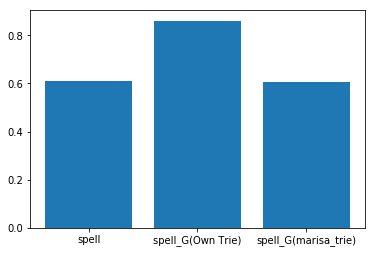

In [23]:
plt.figure()
plt.bar(['spell', 'spell_G(Own Trie)', 'spell_G(marisa_trie)'],
        [time_set.best, time_trie.best, time_marisa_trie.best])
plt.show();

# Spelling correction
<br>
## *Distance* of strings

### Levenshtein distance (edit distance)

Minimal number of single-character edits (insertion, deletion, substitution) needed to change word $a$ into word $b$ 

\begin{equation}
\qquad\operatorname{lev}_{a,b}(i,j) = \begin{cases}
  \max(i,j) & \text{ if} \min(i,j)=0, \\
  \min \begin{cases}
          \operatorname{lev}_{a,b}(i-1,j) + 1 \\
          \operatorname{lev}_{a,b}(i,j-1) + 1 \\
          \operatorname{lev}_{a,b}(i-1,j-1) + 1_{(a_i \neq b_j)}
       \end{cases} & \text{ otherwise.}
\end{cases}
\end{equation}  

where:  

- $1_{(a_i \neq b_j)}$ is an indicator function equal to 0 when $a_i = b_j$ and equal to 1 otherwise  
- $\operatorname{lev}_{a,b}(i,j)$ is the distance of the first $i$ characters of $a$ and the first $j$ characters of $b$

#### Example:
$\qquad\operatorname{lev}_{\text{kitten},\text{sitting}}(6,7) = 3$  
$\qquad$**k**itten $\rightarrow$ *s*itt**e**n $\rightarrow$ sitt*i*n $\rightarrow$ sittin*g* 

### Recursive implementation with exponential runtime

In [24]:
def levenshtein_distance(s: str, t: str):
    if min(len(s), len(t)) == 0:
        return max(len(s),len(t))
    
    cost = 0 if s[-1] == t[-1] else 1
    
    return min(levenshtein_distance(s[:-1], t) +1,
               levenshtein_distance(s, t[:-1]) +1,
               levenshtein_distance(s[:-1], t[:-1]) + cost
              )

In [25]:
def close_strings(s: str, words: Iterable[str],
                  distace_func: Callable[[str, str], int],
                  max_distance: int = 2):
    return [word for word in words if 0 < distace_func(s, word) <= max_distance]

In [26]:
close_strings('hal', words, levenshtein_distance, 2)[:10]

['Ahab', 'Al', 'Aral', 'Ba', 'Baal', 'Bali', 'Ball', 'Ca', 'Cal', 'Cali']

In [27]:
time_lev = %timeit -q -o -r 3 -n 1 close_strings('hal', words, levenshtein_distance, 2)
f"Best: {time_lev.best} s"

'Best: 177.78292495990172 s'

### Utilize dynamic programming  
<br>
Brings down runtime to $O(nm)$ instead of exponential to the power of 3

In [28]:
def levenshtein_dp(s: str, t: str):
    n = len(s) + 1
    m = len(t) + 1
    d = np.zeros((n, m))
    d[:, 0] = range(n)
    d[0, :] = range(m)
    
    for j in range(1, m):
        for i in range(1, n):
            cost = 0 if s[i-1] == t[j-1] else 1
            d[i, j] = min(d[i-1, j] + 1,
                          d[i, j-1] + 1,
                          d[i-1, j-1] + cost
                         )
    return d[n-1,m-1]

In [29]:
time_lev_dp = %timeit -q -o -r 3 -n 1 close_strings('hallo', words, levenshtein_dp, 2)
f"Best: {time_lev_dp.best} s"

'Best: 9.601151441922411 s'

### Damerau-Levenshtein distance
<br>
\begin{equation}
d_{a,b}(i,j) = \begin{cases}
  \max(i,j) & \text{ if} \min(i,j)=0, \\
\min \begin{cases}
          d_{a,b}(i-1,j) + 1 \\
          d_{a,b}(i,j-1) + 1 \\
          d_{a,b}(i-1,j-1) + 1_{(a_i \neq b_j)} \\
          d_{a,b}(i-2,j-2) + 1
       \end{cases} & \text{ if } i,j > 1 \text{ and } a_i = b_{j-1} \text{ and } a_{i-1} = b_j \\
  \min \begin{cases}
          d_{a,b}(i-1,j) + 1 \\
          d_{a,b}(i,j-1) + 1 \\
          d_{a,b}(i-1,j-1) + 1_{(a_i \neq b_j)}
       \end{cases} & \text{ otherwise.}
\end{cases}
\end{equation}  
<br>
Extend `levenshtein_dp()` algorithm to include transpositions.

In [30]:
def damerau_levenshtein(s: str, t: str):
    n = len(s) + 1
    m = len(t) + 1
    d = np.zeros((n, m))
    d[:, 0] = range(n)
    d[0, :] = range(m)
    
    for j in range(1, m):
        for i in range(1, n):
            cost = 0 if s[i-1] == t[j-1] else 1
            d[i, j] = min(d[i-1, j] + 1,
                          d[i, j-1] + 1,
                          d[i-1, j-1] + cost
                         )
            if i > 1 and j > 1 and s[i-1] == t[j-2] and s[i-2] == t[j-1]:
                d[i,j] = min(d[i,j], d[i-2, j-2] + cost)
    return d[n-1,m-1]

# Spelling correction
<br>
## Frequency of strings and *fast* corrector

Use word frequency file by wolfgarbe: [GitHub SymSpell](https://github.com/wolfgarbe/SymSpell)

In [31]:
!echo word count: $(wc -l frequency_dictionary_en_82_765.txt) '\n'
!head -n 5000 frequency_dictionary_en_82_765.txt | tail

word count: 82765 frequency_dictionary_en_82_765.txt 

mrs 12206596
restoration 12202668
convenience 12201623
returning 12197026
ralph 12190683
opposition 12183104
container 12181942
defendant 12169689
warner 12165874
confirmation 12157725


In [32]:
with open('frequency_dictionary_en_82_765.txt') as freq:
    freq = {word: int(cnt) for word, cnt in [line.split() for line in freq.read().split('\n') if line]}

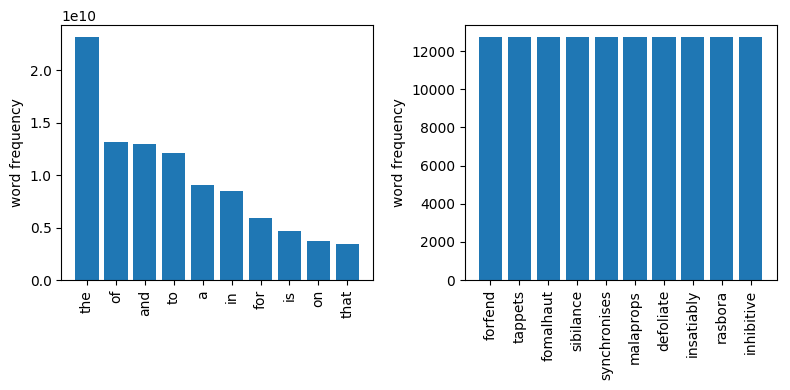

In [33]:
sorted_freq_tuples = sorted([(w, c) for w,c in freq.items()], key=lambda t: -t[1])

words, counts = zip(*sorted_freq_tuples)

plt.figure(figsize=(8,4), dpi=100)
plt.subplot(121)
plt.bar(words[:10], counts[:10])
plt.xticks(rotation='vertical')
plt.ylabel('word frequency')
plt.subplot(122)
plt.bar(words[-10:], counts[-10:])
plt.xticks(rotation='vertical')
plt.ylabel('word frequency')
plt.tight_layout()
plt.savefig('word-freqs.svg');

### Distribution of ten most and least common words
![](word-freqs.svg)

## Symmetric delete spelling correction ([SymSpell](https://towardsdatascience.com/symspell-vs-bk-tree-100x-faster-fuzzy-string-search-spell-checking-c4f10d80a078))

### Idea: Reduce candidates to calc. edit distance for
- pre-calculate possible string by deleting at most n chars
- store deletes in dictionary with candidate correction terms
- calc. deletes for search term and look them up in dictionary
- only calc. edit distance for terms stored as candidate corrections
- sort by edit dist. and frequency


In [34]:
def splits(s: str) -> List[str]:
    return [(s[:i], s[i:]) for i in range(len(s)+1)]

def possible_deletions(s: str, max_edit_dist: int = 1) -> Set[str]:
    deletions = {s}
    for i in range(max_edit_dist):
        i_deletions = set()
        for word in deletions:
            split_words = splits(word)
            i_deletions |= {a+b[1:] for a,b in split_words}
        deletions |= i_deletions
    return deletions
        
    return {a+b[1:] for a,b in splits if b}

In [35]:
class SpellingCorrector:
    def __init__(self, filename, max_edit_dist=2):
        self._dictionary = {}
        self.max_edit_dist = max_edit_dist
        self._init_dict_with_freq_file(filename)
        
    
    def _create_dict_entry(self, word, cnt):
        self._dictionary[word] = ([], int(cnt))
        deletes = possible_deletions(word, self.max_edit_dist)
        for part_word in deletes:
            if part_word in self._dictionary:
                self._dictionary[part_word][0].append(word)
            else:
                self._dictionary[part_word] = ([word], 0)

    

In [36]:
@add_to_class(SpellingCorrector)
def _init_dict_with_freq_file(self, filename):
    with open(filename) as f:
        word_cnt_tuples = [line.split() for line in f.read().split('\n') if line]
        for word, cnt in word_cnt_tuples:
            self._create_dict_entry(word, cnt)

In [37]:
class InvalidMaxEditDist(Exception):
    pass

@add_to_class(SpellingCorrector)
def _suggestion_candidates(self, word, max_edit_dist=2,
                           edit_dist_func=damerau_levenshtein,
                           verbose=False
                          ):
    if not (0 < max_edit_dist <= self.max_edit_dist):
        raise InvalidMaxEditDist(f"max_edit_dist must be in range (0,{self.max_edit_dist}]")
    deletes = possible_deletions(word, max_edit_dist)
    suggestion_dict = {}
    tried_corrections = set()
    dist_func_counter = 0
    for part_word in deletes:
        corrections = self._dictionary.get(part_word, ([], 0))[0]
        for correction in corrections:
            if correction not in tried_corrections:
                tried_corrections.add(correction)
                dist = edit_dist_func(correction, word)
                dist_func_counter += 1
                if  dist <= max_edit_dist:
                    suggestion_dict[correction] = (dist, self._dictionary[correction][1])
    if verbose:
        print(f"Called {edit_dist_func.__name__}() {dist_func_counter} many times.")
    return suggestion_dict


In [38]:
@add_to_class(SpellingCorrector)
def suggestions(self, word: str, verbose=False, **kwargs):
    word = word.lower()
    candidates = self._suggestion_candidates(word, verbose=verbose, **kwargs)
    sorted_candidates = sorted(candidates.items(), key=lambda tup: (tup[1][0], -tup[1][1]))
    if verbose:
        return sorted_candidates
    return [word for word, _ in sorted_candidates]

In [39]:
corr = SpellingCorrector('frequency_dictionary_en_82_765.txt', max_edit_dist=2)

### Small slice of the underlying dictionary structure

In [40]:
[(k, (data[0][:3]+['...'], data[1])) for k, data in list(corr._dictionary.items())[:5]]

[('the', (['the', 'other', 'they', '...'], 23135851162)),
 ('he', (['he', 'when', 'here', '...'], 842847219)),
 ('e', (['the', 'be', 'are', '...'], 0)),
 ('th', (['the', 'that', 'this', '...'], 0)),
 ('t', (['the', 'to', 'it', '...'], 0))]

## So lets benchmark it!

In [41]:
time_corr = %timeit -q -o corr.suggestions("Hallo", max_edit_dist=2)
f"Best: {time_corr.best} s"
corr.suggestions("Hallo", verbose=True)[:5]

'Best: 0.013340204500127583 s'

Called damerau_levenshtein() 191 many times.


[('hall', (1.0, 61265768)),
 ('hello', (1.0, 32960381)),
 ('halo', (1.0, 6194202)),
 ('halls', (1.0, 4607236)),
 ('halle', (1.0, 1568027))]

## That's a speed increase of *several* orders of magnitude!

## But is the corrector actually any good?

### Misspell data  
<br>
We're using spelling error data formatted by [Roger Mitton](http://www.dcs.bbk.ac.uk/~ROGER/) to test the corrector.  
`aspell.dat`
> The aspell file contains 531 misspellings of 450 words. It is derived from one assembled by Atkinson [(click here)](http://aspell.net/test/batch0.tab) for testing the [GNU Aspell spellchecker](http://aspell.net/). 

`wikipedia.dat`
> The wikipedia file contains 2,455 misspellings of 1,922 words. It is a list of misspellings made by Wikipedia editors [(click here)](http://en.wikipedia.org/wiki/Wikipedia:List_of_common_misspellings). 

In [42]:
def parse_misspell_data(filename):
    with open(filename) as f:
        lines = [line for line in f.read().split('\n') if line]
        misspell_data = {}
        misspelled_words_cnt = 0
        cursor = ''
        for line in lines:
            if line.startswith('$'):
                cursor = line[1:]
                misspell_data[cursor] = []
                continue
            misspell_data[cursor].append(line)
            misspelled_words_cnt += 1
        return misspell_data, misspelled_words_cnt

In [43]:
def score(misspell_data: Dict[str, List[str]] ,
          corrector_func: Callable[[str], Iterable[str]] ,
          consider_corrections_count=5):
    score = 0
    for word, misspells in misspell_data.items():
        for ms_word in misspells:
            try:
                corrections = corrector_func(ms_word)
                score += 1 if word in corrections[:consider_corrections_count] else 0
            except IndexError:
                pass
    return score

In [44]:
def test_with_spell_data_and_create_graph(filename, corrector, max_edit_dist=2, max_lookup=5):
    misspell_data, misspelled_words_cnt = parse_misspell_data(filename)
    plot_cols = max_edit_dist
    plt.figure(figsize=(4*plot_cols, 4), dpi=100)
    for edit_dist in range(1, max_edit_dist+1):
        corrector_fixed_dist = partial(corrector, max_edit_dist=edit_dist)
        score_data = [score(misspell_data, corrector_fixed_dist, lookup)/misspelled_words_cnt 
                      for lookup in range(1, max_lookup+1)]
        print(score_data)
        plt.subplot(1, plot_cols, edit_dist)
        plt.gca().set_ylim([0, 1.0])
        plt.bar(range(1, max_lookup+1), score_data)
        plt.title(f"Max edit dist: {edit_dist}")
        plt.ylabel('score in %')
        plt.xlabel('max lookup')
    plt.tight_layout()
    plt.savefig(f'{filename}-score-graph.svg');

[0.3860640301318267, 0.4595103578154426, 0.4839924670433145, 0.4915254237288136, 0.4934086629001883, 0.4934086629001883, 0.4934086629001883, 0.4952919020715631, 0.4952919020715631, 0.4952919020715631]
[0.5103578154425612, 0.6421845574387948, 0.6836158192090396, 0.7024482109227872, 0.71939736346516, 0.7212806026365348, 0.7288135593220338, 0.7306967984934086, 0.7306967984934086, 0.7325800376647834]
[0.6545824847250509, 0.734826883910387, 0.7523421588594704, 0.7596741344195519, 0.7629327902240326, 0.7641547861507129, 0.764562118126273, 0.7657841140529531, 0.7665987780040733, 0.7674134419551935]
[0.7340122199592668, 0.835030549898167, 0.8668024439918534, 0.8806517311608961, 0.8887983706720978, 0.8928716904276985, 0.8965376782077393, 0.8993890020366598, 0.9014256619144603, 0.9022403258655805]


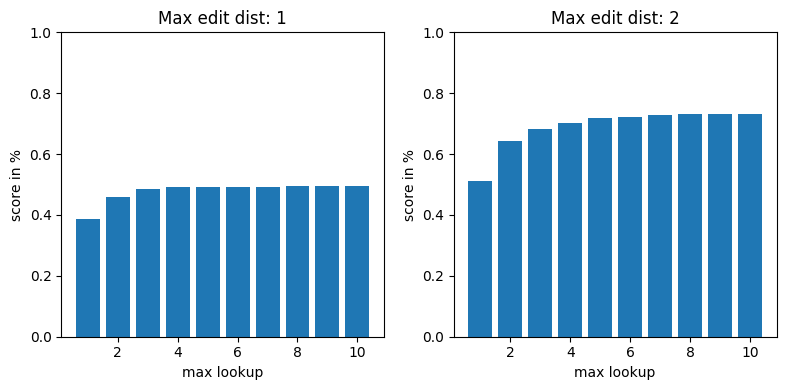

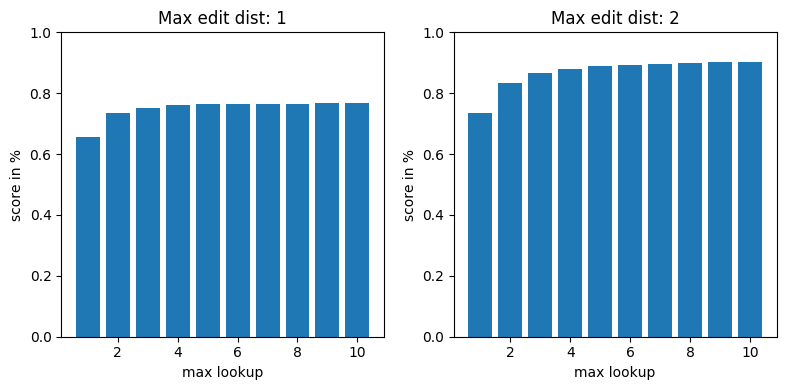

In [47]:
test_with_spell_data_and_create_graph('aspell.dat', corr.suggestions, max_lookup=10)
test_with_spell_data_and_create_graph('wikipedia.dat', corr.suggestions, max_lookup=10)

# Spelling corrector: Conclusion

![](aspell.dat-score-graph.svg)
(aspell.dat)

![](wikipedia.dat-score-graph.svg)
(wikipedia.dat)

# Thank you for your attention
<br>
<br>
All slides, the notebooks, the word files, etc. are available on the [GWDG Gitlab](https://gitlab.gwdg.de/) under [programming-pearls-spelling-checker](https://gitlab.gwdg.de/robinwilliam.hundt/programming-pearls-spelling-checker)

# References  

- Programming Pearls, a spelling checker. Jon Bentley. Communications of the ACM, May 1985 Volume 28 Number 5
- 1000x Faster Spelling Correction algorithm, Wolf, [blog.faroo.com](http://blog.faroo.com/2012/06/07/improved-edit-distance-based-spelling-correction/) (published June 7, 2012)
- How to Write a Spelling Corrector, Peter Norvig, [norvig.com](http://norvig.com/spell-correct.html) (published Feb 2007 to August 2016)  

## Data sources
- `big.txt`, Peter Norvig, [norvig.com](http://norvig.com/big.txt)
- `frequency_dictionary_en_82_765.txt`, Wolf Garbe, [github.com](https://github.com/wolfgarbe/SymSpell/blob/master/SymSpell/frequency_dictionary_en_82_765.txt)
- `aspell.dat` and `wikipedia.dat`, Roger Mitton, [dcs.bbk.ac.uk](http://www.dcs.bbk.ac.uk/~ROGER/corpora.html)

## Libraries
- [marisa_trie](https://github.com/pytries/marisa-trie) (MIT license)  
- [numpy](https://github.com/numpy/numpy) (BSD-new license)  
- [matplotlib](https://github.com/matplotlib/matplotlib)  
- [pympler](https://github.com/pympler/pympler) (Apache-2.0)